In [1]:
import importlib
import logging
import nanomotif as nm
from nanomotif.candidate import Motif
import polars as pl
from polars import col, lit
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
importlib.reload(nm)

<module 'nanomotif' from '/user_data/sh/motif-finder/nanomotif/__init__.py'>

In [2]:
def plot_search_graph(graph, label_mean_min = 0.3, ax=None):
    pos = nx.kamada_kawai_layout(graph)
    options = {"edgecolors": "tab:gray", "node_size": 800, "alpha": 0.5}
    visited = [graph.nodes[i]["visited"] for i in graph.nodes]
    node_colors = [graph.nodes[i]["model"].mean() for i in graph.nodes]
    node_sizes = [(0.05 + i)*50 for i in visited]
    nodes = nx.draw_networkx_nodes(graph, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.viridis, alpha=1, margins=0.0, ax = ax)
    nx.draw_networkx_edges(graph, pos, width=0.2, alpha=1, ax=ax);

    stripped_labels = {i: i.rstrip(".").lstrip(".") for i in graph.nodes if graph.nodes[i]["model"].mean() > label_mean_min}
    nx.draw_networkx_labels(graph, pos, stripped_labels, font_size=7, font_color="black");
    plt.colorbar(nodes)
def nxgraph_to_dataframe(graph):
    return pl.DataFrame({
        "sequence":[i for i in graph.nodes],
        "model":[graph.nodes[i]["model"] for i in graph.nodes],
        "score":[graph.nodes[i]["score"] for i in graph.nodes]
    }).sort("score", descending=True)



def split_motif_string(s):
    """
    Split a string into a list of characters, keeping bracketed characters together.

    Parameters:
    - s (str): The input string.

    Returns:
    - list: A list of characters, where bracketed characters are kept together.
    """
    result = []
    i = 0
    while i < len(s):
        if s[i] == "[":
            j = s.find("]", i)
            result.append(s[i+1:j])
            i = j + 1
        else:
            result.append(s[i])
            i += 1
    return result

def find_best_candidates(methylation_sequences, sequence, pileup, min_kl = 0.3, max_dead_ends = 4):
    padding = methylation_sequences.sequence_length // 2
    root_motif = Motif("." * (2 * padding + 1), padding + 1) # Represent all possible motifs
    methylation_sequences_subset = methylation_sequences.convert_to_DNAarray()
    best_candidates = []
    total_sequences = len(methylation_sequences.sequences)
    continue_search = True
    dead_ends = 0
    motif_graph = None

    while continue_search:
        if dead_ends >= max_dead_ends:
            logging.info("Stopping search, too many low scoring candidates")
            break
        # Find the initial guess within the tree
        motif_graph, naive_guess = nm.evaluate.a_star_search(
            root_motif, 
            sequence, 
            pileup, 
            methylation_sequences_subset, 
            motif_graph = motif_graph,
            min_kl = min_kl,
            max_rounds_since_new_best = 20
        )

        # If there is no naive guess, stop the search
        if naive_guess == root_motif:
            logging.info("No naive guess found, stopping search")
            break
        guess = naive_guess
        next_guess = None
        while guess != next_guess:
            # Find the best guess within the subtree of the naive guess
            guess = next_guess
            motif_graph, next_guess = nm.evaluate.a_star_search(
                naive_guess, 
                sequence, 
                pileup, 
                methylation_sequences_subset, 
                motif_graph = motif_graph,
                min_kl = min_kl,
                max_rounds_since_new_best = 4
            )

        # Remove new candidate from methylation sequences
        seq_before = methylation_sequences_subset.shape[0]
        methylation_sequences_subset = methylation_sequences_subset.get_sequences_without_match(guess.one_hot())

        # Check if we should continue the search
        seq_remaining = methylation_sequences_subset.shape[0]
        seq_remaining_percent = seq_remaining/total_sequences
        logging.info(f"{guess}, {seq_before-seq_remaining} seqs. model: {motif_graph.nodes[guess]['model']}. ({100*seq_remaining_percent:.1f} % left)")

        if (seq_before - seq_remaining)/seq_before < 0.1:
            dead_ends += 1
            logging.info("Motif is too specific")
            continue
        if motif_graph.nodes[guess]["model"].mean() < 0.1:
            dead_ends += 1
            logging.info(f"Candidate has low score. {dead_ends} so far")
            continue

        if (seq_remaining/total_sequences) < 0.01:
            logging.info("Stopping search, too few sequences left")
            break
        else:
            logging.info("Continuing search")
            best_candidates.append(guess)
    return motif_graph, best_candidates




In [3]:
assembly = nm.load_assembly("../data/ecoli/assembly.polished.fasta")
ecoli = nm.load_pileup("../data/ecoli/modkit.pileup.bed").pileup \
    .filter(pl.col("contig") == "contig_3") \
    .filter(pl.col("mod_type") == "m") \
    .filter(pl.col("Nvalid_cov") > 5) \
    .filter(pl.col("fraction_mod") > 0.8) 

In [4]:
sequence = assembly.assembly["contig_3"]
padding = 15
index_fwd = ecoli.filter(pl.col("strand") == "+").get_column("position").to_list()
index_rev = ecoli.filter(pl.col("strand") == "-").get_column("position").to_list()
sequences_fwd = sequence.sample_at_indices(index_fwd, padding)
sequences_rev = sequence.sample_at_indices(index_rev, padding).reverse_compliment() 
methylation_sequences = sequences_fwd + sequences_rev
methylation_sequences = methylation_sequences.convert_to_DNAarray()

In [5]:
ecoli_graph, ecoli_guesses = nm.evaluate.a_star_search(
    Motif("." * (2 * padding + 1), padding + 1),
    sequence,
    ecoli,
    methylation_sequences,
    min_kl=0.2
)

DEBUG: ............................... | BetaBernoulliModel(alpha=141464, beta=4329) 
DEBUG: ..................G............ | BetaBernoulliModel(alpha=4704661, beta=131222) 
DEBUG: ...............C..G............ | BetaBernoulliModel(alpha=4697378, beta=130221) 
DEBUG: ...............C............... | BetaBernoulliModel(alpha=4745642, beta=138251) 
DEBUG: ..............CC..G............ | BetaBernoulliModel(alpha=2757214, beta=71640) 
DEBUG: ..............CC............... | BetaBernoulliModel(alpha=2721274, beta=72668) 
DEBUG: ..............CC.GG............ | BetaBernoulliModel(alpha=2348696, beta=57026) 
DEBUG: ..............CC[AT]GG............ | BetaBernoulliModel(alpha=2348696, beta=57026) 
DEBUG: ..............CC[AT].G............ | BetaBernoulliModel(alpha=2348709, beta=57027) 
DEBUG: ..............CC[AT].............. | BetaBernoulliModel(alpha=2350187, beta=57267) 
DEBUG: ..............CC[AT]G............. | BetaBernoulliModel(alpha=2349405, beta=57149) 
DEBUG: ............

DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x7fa167100cd0>


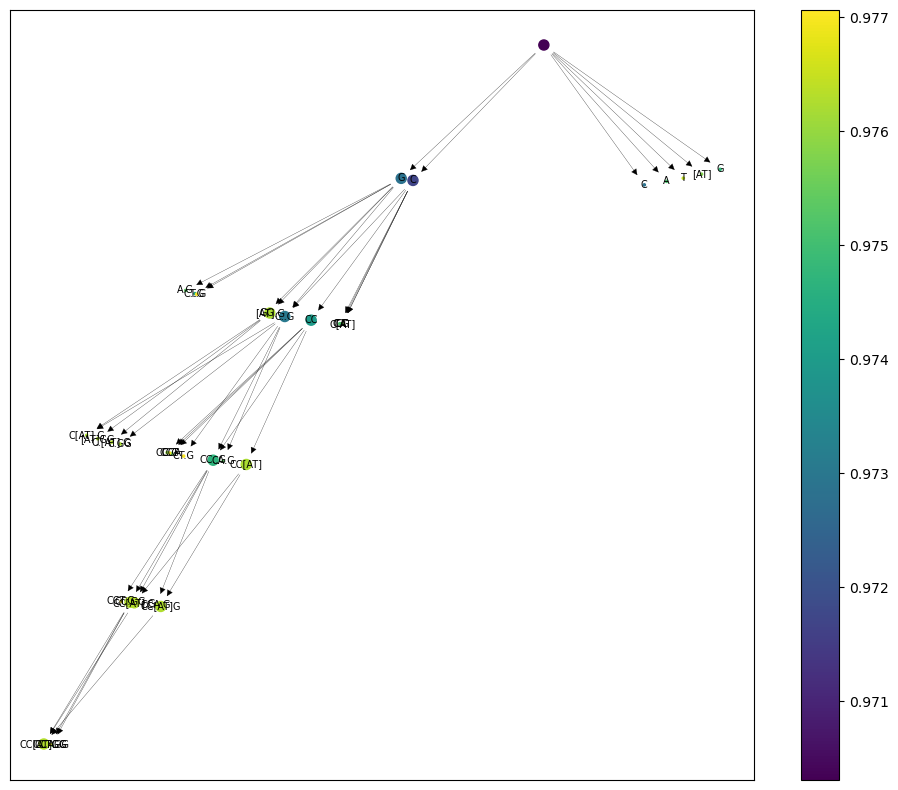

In [7]:
fig, ax = plt.subplots(figsize=(12, 10))
plot_search_graph(ecoli_graph, ax = ax, label_mean_min = 0);


In [ ]:
assembly = nm.load_assembly("../data/geobacillus/assembly.polished.fasta")
geobacillus = nm.load_pileup("../data/geobacillus/modkit.pileup.bed").pileup \
    .filter(pl.col("contig") == "contig_3") \
    .filter(pl.col("mod_type") == "a") \
    .filter(pl.col("Nvalid_cov") > 10) \
    .filter(pl.col("fraction_mod") > 0.8) 

In [ ]:
sequence = assembly.assembly["contig_3"]
padding = 10
methylation_index_fwd = geobacillus \
    .filter(pl.col("strand") == "+")  \
    .get_column("position").to_list()
methylation_index_rev = geobacillus \
    .filter(pl.col("strand") == "-") \
    .get_column("position").to_list()
methylation_sequences_fwd = nm.seq.EqualLengthDNASet(
    [nm.seq.DNAsequence(sequence[(i - padding):(i + padding + 1)]) for i in methylation_index_fwd if (i > padding) and (i < (len(sequence) - padding))]
)
methylation_sequences_rev = nm.seq.EqualLengthDNASet(
    [nm.seq.DNAsequence(sequence[(i - padding):(i + padding + 1)]).reverse_complement() for i in methylation_index_rev if (i > padding) and (i < (len(sequence) - padding))]
)
methylation_sequences = methylation_sequences_fwd + methylation_sequences_rev

In [ ]:
gb_graph, gb_guesses = find_best_candidates(
    methylation_sequences,
    sequence,
    geobacillus,
    min_kl=0.2
)

In [ ]:
gb_guesses


In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
plot_search_graph(gb_graph, ax=ax, label_mean_min = 0.6);


In [ ]:
assembly = nm.load_assembly("../data/mruber/assembly.polished.fasta")
mruber = nm.load_pileup("../data/mruber/modkit.pileup.bed").pileup \
    .filter(pl.col("contig") == "contig_1") \
    .filter(pl.col("mod_type") == "a") \
    .filter(pl.col("Nvalid_cov") > 10) \
    .filter(pl.col("fraction_mod") > 0.85) 

In [ ]:
sequence = assembly.assembly["contig_1"]
padding = 15
methylation_index_fwd = mruber \
    .filter(pl.col("strand") == "+")  \
    .get_column("position").to_list()
methylation_index_rev = mruber \
    .filter(pl.col("strand") == "-") \
    .get_column("position").to_list()
methylation_sequences_fwd = nm.seq.EqualLengthDNASet(
    [nm.seq.DNAsequence(sequence[(i - padding):(i + padding + 1)]) for i in methylation_index_fwd if (i > padding) and (i < (len(sequence) - padding))]
)
methylation_sequences_rev = nm.seq.EqualLengthDNASet(
    [nm.seq.DNAsequence(sequence[(i - padding):(i + padding + 1)]).reverse_complement() for i in methylation_index_rev if (i > padding) and (i < (len(sequence) - padding))]
)
methylation_sequences = methylation_sequences_fwd + methylation_sequences_rev

In [ ]:
methylation_sequences.plot_pssm()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [ ]:
mr_graph, mr_guesses = find_best_candidates(
    methylation_sequences,
    sequence,
    mruber,
    min_kl=0.2
)

In [ ]:
nxgraph_to_dataframe(mr_graph) \
    .filter(col("sequence").is_in(mr_guesses))

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plot_search_graph(mr_graph, label_mean_min=0.45, ax=ax);

In [ ]:
assembly = nm.load_assembly("../data/ecoli_neg/assembly.polished.fasta")
ec_neg = nm.load_pileup("../data/ecoli_neg/modkit.pileup.bed").pileup \
    .filter(pl.col("contig") == "contig_1") \
    .filter(pl.col("mod_type") == "a") \
    .filter(pl.col("Nvalid_cov") > 10) \
    .filter(pl.col("fraction_mod") > 0.85) 
sequence = assembly.assembly["contig_1"]
padding = 15
methylation_index_fwd = ec_neg \
    .filter(pl.col("strand") == "+")  \
    .get_column("position").to_list()
methylation_index_rev = ec_neg \
    .filter(pl.col("strand") == "-") \
    .get_column("position").to_list()
methylation_sequences_fwd = nm.seq.EqualLengthDNASet(
    [nm.seq.DNAsequence(sequence[(i - padding):(i + padding + 1)]) for i in methylation_index_fwd if (i > padding) and (i < (len(sequence) - padding))]
)
methylation_sequences_rev = nm.seq.EqualLengthDNASet(
    [nm.seq.DNAsequence(sequence[(i - padding):(i + padding + 1)]).reverse_complement() for i in methylation_index_rev if (i > padding) and (i < (len(sequence) - padding))]
)
methylation_sequences = methylation_sequences_fwd + methylation_sequences_rev

In [ ]:
ec_neg_graph, ec_neg_guesses = find_best_candidates(
    methylation_sequences,
    sequence,
    ec_neg,
    min_kl=0.2
)

In [ ]:
ec_neg_guesses

In [ ]:
pl.concat([
nxgraph_to_dataframe(ec_neg_graph) \
    .filter(col("sequence") in ec_neg_guesses) ,
    nxgraph_to_dataframe(ec_neg_graph) \
    .filter(col("sequence") in ec_neg_guesses) 
])